**Supplementary Material**

Technische Universität München, Fakultät für Informatik, Dr. Tobias Lasser, Dr. Maximilian Baust, Richard Brosig, Jakob Vogel, Oliver Zettinig, Nicola Rieke, Anca Stefanoiu, Rüdiger Göbl, 2009-2017

This code has originally been written by Maximilian Baust and has been adapted to match into the structure of the exercises. The original file comment follows below.

This code of for educational purposes only and is based on the ideas of Lucas and Kanade (Lucas B D and Kanade T 1981, An iterative image registration technique with an application to stereo vision. Proceedings of Imaging understanding workshop, pp 121--130)

The video is taken from Dirk-Jan Kroon, Lucas Kanade affine template tracking, MATLAB central, File Exchange, Copyright (c) 2009, Dirk-Jan Kroon, All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

    * Redistributions of source code must retain the above copyright 
      notice, this list of conditions and the following disclaimer.
    * Redistributions in binary form must reproduce the above copyright 
      notice, this list of conditions and the following disclaimer in 
      the documentation and/or other materials provided with the distribution
      
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

![title](Pic_1.png)

<IPython.core.display.Javascript object>


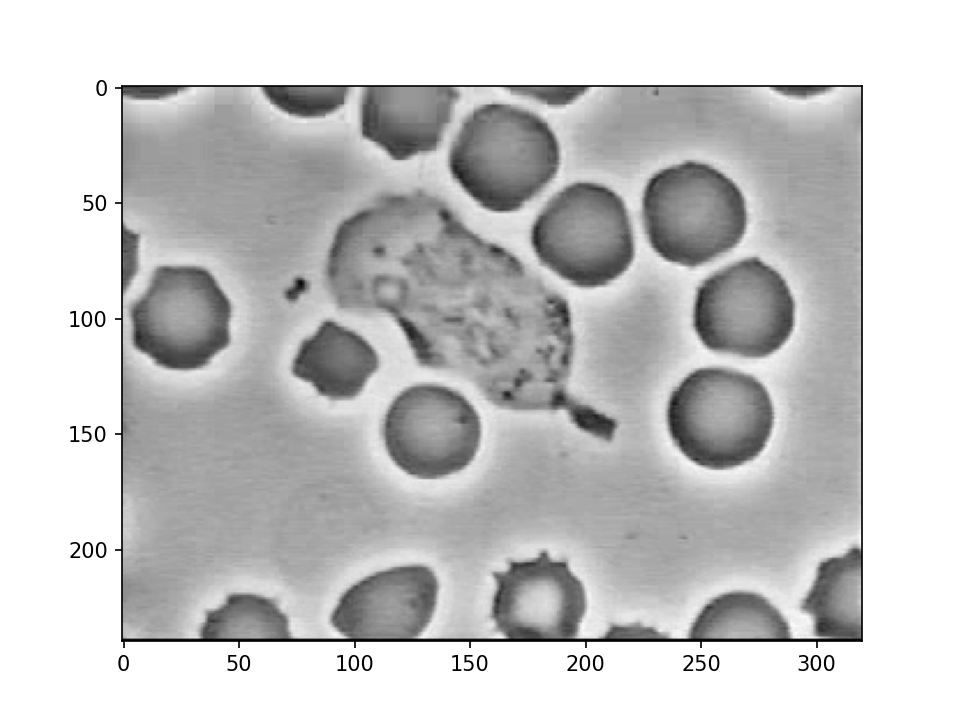

In [3]:
%matplotlib notebook

import scipy.io as sio
import scipy.ndimage as ndimage
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


def golub(a, b):
    # QR decomposition of A
    [q, r] = np.linalg.qr(a)

    # compute new b
    bnew = np.matmul(q.T, b)

    # get size of A
    [m, n] = a.shape
    # compute solution
    x = np.linalg.solve(r[0:n, :], bnew[0:n])

    # compute residual
    residual = np.sqrt(np.sum((np.matmul(a, x) - b)**2))

    return x, residual


# load video and set up coordinate system
# mat_contents = sio.loadmat('tracking-cars.mat')
mat_contents = sio.loadmat('tracking-leukocyte.mat')

# convert movie to double
movie = np.asarray(mat_contents['movie'], np.double)

# get first image (movie is a 3-d array, where the 3rd dimension is the frame number)
Is = movie[:, :, 0]

# generate coordinate system
[r, c] = Is.shape
x = list(range(0, c))
y = list(range(0, r))

# display image
plt.imshow(Is, cmap='gray')

# get center point for patch P
#tr = plt.ginput(1)

<IPython.core.display.Javascript object>


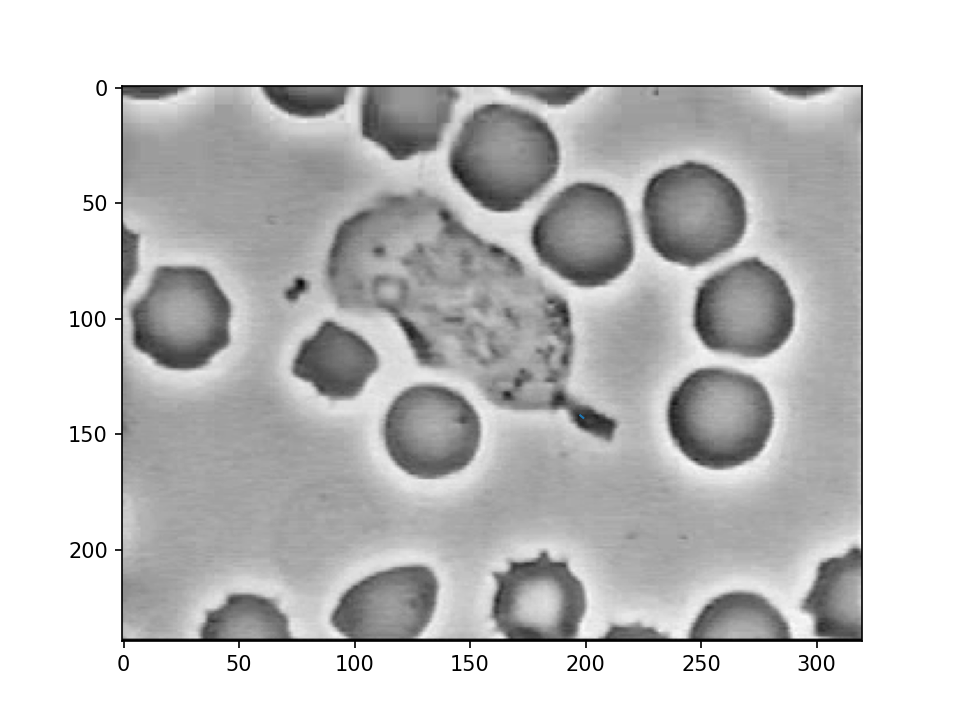

In [4]:
#tr_x = [tr[0][0]]
#tr_y = [tr[0][1]]
# for testing you can use these coordinates
tr_x = [200-1]
tr_y = [144-1]

# track the patch
# define 'radius' size of patch
t = 10

# set up patch coordinate system
[tx, ty] = np.meshgrid(range(-t, t+1), range(-t, t+1))
tx = tx.flatten()
ty = ty.flatten()

# loop over all images
lines = []
for i in range(1, movie.shape[2]):
    # get target image
    It = movie[:, :, i]
    
    # compute function and derivatives
    # compute gradient of source image, the result are two 'images'
    # storing d_xI_s and d_yI_s
    [dyIs, dxIs] = np.gradient(Is)
    
    # get all pixels of patch in d_xI_s
    # and store it in a variable called A1.
    # Note that we have to take the current endpoint 
    # of the trajectory (tr_x[-1],tr_y[-1]).
    A1 = ndimage.map_coordinates(dxIs.T, (tr_x[-1] + tx, tr_y[-1] + ty), order=2)

    # get all pixels of patch in d_yI_s
    # and store it in a variable called A2.
    A2 = ndimage.map_coordinates(dyIs.T, (tr_x[-1] + tx, tr_y[-1] + ty), order=2)
    
    # get all pixels of patch in I_t - I_s 
    # and store it in a variable called b.
    b = ndimage.map_coordinates(It.T, (tr_x[-1] + tx, tr_y[-1] + ty), order=2) - \
        ndimage.map_coordinates(Is.T, (tr_x[-1] + tx, tr_y[-1] + ty), order=2)
    
    # set up equation system
    # for that transform A1, A2 and b to column vectors
    A = np.stack((A1.T.flatten(), A2.T.flatten()), axis=-1)
    b = b.flatten()
    
    # solve equation system using Golub's algorithm
    [v, res] = golub(A, b)
    
    # update trajectory
    # Attention! I_s(x+v) ~ I_t(x)
    # since we show always It, we have to subtract v !
    tr_x.append(tr_x[-1] - v[0])
    tr_y.append(tr_y[-1] - v[1])
    lines.append((np.asarray(tr_x), np.asarray(tr_y)))

    # update Is
    Is = It

# plot tracking output
fig = plt.figure()
ax = plt.axes()

line, = ax.plot([], [], lw=1)
img = ax.imshow(movie[:,:,0], cmap='gray')

# Initialization function: plot the background of each frame
def init():
    line.set_data(lines[0][0], lines[0][1])
    img.set_data(movie[:,:,0])
    return line,

# Animation function which updates figure data.  This is called sequentially
def animate(i):
    line.set_data(lines[i][0], lines[i][1])
    img.set_data(movie[:,:,i])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(lines), interval=50)

# Call function to display the animation
_ = HTML(anim.to_html5_video())